## Imports

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core
import os
from tqdm.notebook import tqdm

## Evaluate image with OpenVino model

In [62]:
ie = Core()
model = ie.read_model(model=os.path.normpath(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\omz_emotion_recognition_model\emotion-recognition-retail-0003.xml"))
compiled_model = ie.compile_model(model=model, device_name="CPU")

output_layer = next(iter(compiled_model.outputs))
input_layer = next(iter(compiled_model.inputs))

In [63]:
print(input_layer)
print(output_layer)

<ConstOutput: names[data] shape{1,3,64,64} type: f32>
<ConstOutput: names[prob_emotion] shape{1,5,1,1} type: f32>


In [65]:
ovm_classes_to_idx = {'Neutral':0, 'Happy':1, 'Sad':2, 'Surprise':3, 'Angry':4}
idx_to_ovm_classes = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Angry'}

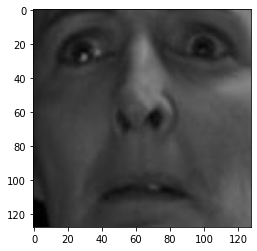

In [68]:
# The MobileNet model expects images in RGB format
image = cv2.cvtColor(cv2.imread(filename="data/scared.jpg"), code=cv2.COLOR_BGR2RGB)

# resize to MobileNet image shape
input_image = cv2.resize(src=image, dsize=(64, 64))

# reshape to model input shape
input_image = np.expand_dims(input_image.transpose(2, 0, 1), 0)
plt.imshow(image);

In [69]:
result_infer = compiled_model(inputs=[input_image])[output_layer]
result_index = np.argmax(result_infer)
print(idx_to_ovm_classes.get(result_index))

Angry


## Evaluation of EfficientNet B0 in OpenVino - 13.69% Accuracy

In [37]:
ie = Core()
model = ie.read_model(model=os.path.normpath(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\FP32\enet_b0_8.xml"))
compiled_model = ie.compile_model(model=model, device_name="CPU")

In [38]:
output_layer = next(iter(compiled_model.outputs))
input_layer = next(iter(compiled_model.inputs))
print(input_layer)
print(output_layer)

<ConstOutput: names[x.1] shape{1,3,224,224} type: f32>
<ConstOutput: names[653] shape{1,8} type: f32>


In [39]:
class_to_idx = {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}
idx_to_class = {0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}

In [40]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces\Val_AFEW'

In [41]:
def transforms(filepath):
    image = cv2.cvtColor(cv2.imread(filename=filepath), code=cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(src=image, dsize=(224, 224))
    input_image = np.expand_dims(input_image.transpose(2, 0, 1), 0)
    return input_image

In [42]:
def softmax(input):
    modified_input = np.subtract(input, input.max(axis=0, keepdims=True))

    # Get unnormalized probabilities
    exp_values = np.exp(modified_input - np.max(modified_input, axis=0, keepdims=True))
    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)

    return probabilities

In [43]:
y_val,y_scores_val=[],[]

for class_name in os.listdir(DATA_DIR):
    if class_name in class_to_idx:
        #print(class_name)
        class_dir=os.path.join(DATA_DIR,class_name)
        y=class_to_idx[class_name]
        for video_name in tqdm(os.listdir(class_dir)):
            video_dir = os.path.join(class_dir,video_name)
            for img_name in os.listdir(video_dir):
                if 'noface' not in img_name:
                    filepath=os.path.join(video_dir,img_name)
                    input_image = transforms(filepath)
                    scores = compiled_model(inputs=[input_image])[output_layer]
                    #print(scores.shape)
                    y_scores_val.append(softmax(scores[0]))
                    y_val.append(y)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(19962, 8) (19962,)


In [44]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(y_val)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i], (y_pred[y_val==i]==i).sum(), (y_val==i).sum(), 100*_val_acc))

13.686003406472297
Angry 563/3297 acc: 17.076130
Contempt 0/0 acc: nan
Disgust 44/2485 acc: 1.770624
Fear 246/1703 acc: 14.445097
Happy 1205/3320 acc: 36.295181
Neutral 27/3693 acc: 0.731113
Sad 618/3356 acc: 18.414779
Surprise 29/2108 acc: 1.375712


D:\Users\amira\AppData\Local\Temp\ipykernel_1104\1344098004.py:8: RuntimeWarning: invalid value encountered in long_scalars
  _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()


In [45]:
# Model was trained on 8 emotions on AffectNet so we have to delete 1 emotion that is not on AFEW
сontempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=сontempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=сontempt_idx
y_val_new=np.array([y if y<сontempt_idx else y-1 for y in y_val if y!=сontempt_idx])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(19962, 7)
13.696022442641018


## Evaluation of OpenModelZoo Model [emotions-recognition-retail-0003](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/emotions-recognition-retail-0003) (5 emotions) - 40.39%

In [3]:
ie = Core()
model = ie.read_model(model=os.path.normpath(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\omz_emotion_recognition_model\emotion-recognition-retail-0003.xml"))
compiled_model = ie.compile_model(model=model, device_name="CPU")

In [4]:
output_layer = next(iter(compiled_model.outputs))
input_layer = next(iter(compiled_model.inputs))
print(input_layer)
print(output_layer)

<ConstOutput: names[data] shape{1,3,64,64} type: f32>
<ConstOutput: names[prob_emotion] shape{1,5,1,1} type: f32>


In [5]:
def transforms(filepath):
    image = cv2.cvtColor(cv2.imread(filename=filepath), code=cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(src=image, dsize=(64, 64))
    input_image = np.expand_dims(input_image.transpose(2, 0, 1), 0)
    return input_image

In [6]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces\Val_AFEW'

In [7]:
def softmax(input):
    modified_input = np.subtract(input, input.max(axis=0, keepdims=True))

    # Get unnormalized probabilities
    exp_values = np.exp(modified_input - np.max(modified_input, axis=0, keepdims=True))
    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)

    return probabilities

In [8]:
ovm_classes_to_idx = {'Neutral':0, 'Happy':1, 'Sad':2, 'Surprise':3, 'Angry':4}
idx_to_ovm_classes = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Angry'}

In [9]:
y_val,y_scores_val=[],[]

for class_name in os.listdir(DATA_DIR):
    if class_name in ovm_classes_to_idx:
        #print(class_name)
        class_dir=os.path.join(DATA_DIR,class_name)
        y=ovm_classes_to_idx[class_name]
        for video_name in tqdm(os.listdir(class_dir)):
            video_dir = os.path.join(class_dir,video_name)
            for img_name in os.listdir(video_dir):
                if 'noface' not in img_name:
                    filepath=os.path.join(video_dir,img_name)
                    input_image = transforms(filepath)
                    scores = compiled_model(inputs=[input_image])[output_layer]
                    #print(scores.shape)
                    y_scores_val.append(softmax(scores[0]))
                    y_val.append(y)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(15774, 5, 1, 1) (15774,)


In [15]:
y_pred=np.argmax(y_scores_val,axis=1).squeeze()
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(y_val)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_ovm_classes[i], (y_pred[y_val==i]==i).sum(), (y_val==i).sum(), 100*_val_acc))

40.39558767592241
Neutral 899/3693 acc: 24.343352
Happy 1384/3320 acc: 41.686747
Sad 2390/3356 acc: 71.215733
Surprise 599/2108 acc: 28.415560
Angry 1100/3297 acc: 33.363664


## EfficientNet B0 before convertation to OpenVino (7 emotions - 36.59% / 5 emotions - 49.12%)

In [51]:
import torch
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
from PIL import Image
import numpy as np

In [52]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces\Val_AFEW'
IMG_SIZE = 224

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [53]:
class_to_idx = {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}
idx_to_class = {0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8'
device = 'cuda:0'
model = torch.load(PATH)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [54]:
def softmax(input):
    modified_input = np.subtract(input, input.max(axis=0, keepdims=True))

    # Get unnormalized probabilities
    exp_values = np.exp(modified_input - np.max(modified_input, axis=0, keepdims=True))
    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)

    return probabilities

In [55]:
y_val,y_scores_val=[],[]

for class_name in os.listdir(DATA_DIR):
    if class_name in class_to_idx:
        class_dir=os.path.join(DATA_DIR,class_name)
        y=class_to_idx[class_name]
        for video_name in tqdm(os.listdir(class_dir)):
            video_dir = os.path.join(class_dir,video_name)
            for img_name in os.listdir(video_dir):
                if 'noface' not in img_name:
                    filepath=os.path.join(video_dir,img_name)
                    img = Image.open(filepath)
                    img_tensor = test_transforms(img)
                    img_tensor.unsqueeze_(0)
                    scores = model(img_tensor.to(device))
                    scores=scores[0].data.cpu().numpy()
                    #print(scores.shape)
                    y_scores_val.append(softmax(scores))
                    y_val.append(y)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(19962, 8) (19962,)


In [56]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(y_val)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_pred[y_val==i]==i).sum(),(y_val==i).sum(),100*_val_acc))

35.22192165113716
Angry 1220/3297 acc: 37.003336
Contempt 0/0 acc: nan
Disgust 372/2485 acc: 14.969819
Fear 671/1703 acc: 39.401057
Happy 1577/3320 acc: 47.500000
Neutral 798/3693 acc: 21.608448
Sad 1910/3356 acc: 56.912992
Surprise 483/2108 acc: 22.912713


D:\Users\amira\AppData\Local\Temp\ipykernel_1104\1864895788.py:8: RuntimeWarning: invalid value encountered in long_scalars
  _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()


In [57]:
# Model was trained on 8 emotions on AffectNet so we have to delete 1 emotion that is not on AFEW
сontempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=сontempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=сontempt_idx
y_val_new=np.array([y if y<сontempt_idx else y-1 for y in y_val if y!=сontempt_idx])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(19962, 7)
36.59452960625188


5 emotions that model from OpenVino's OMZ can classify

In [59]:
irrelevant_idxs = [class_to_idx['Contempt'], class_to_idx['Disgust'], class_to_idx['Fear']]

y_scores_val_filtered=y_scores_val[:, [i not in irrelevant_idxs for i in idx_to_class]]
print(y_scores_val_filtered.shape)

y_pred=np.argmax(y_scores_val_filtered,axis=1)
other_indices=[i not in irrelevant_idxs for i in y_val]
y_val_new=np.array([y if y<class_to_idx['Contempt'] else y-3 for y in y_val if y not in irrelevant_idxs])
acc=100.0*np.mean(y_val_new==y_pred[other_indices])
print(acc)

(19962, 5)
49.125142639786986


## Efficient Net b0 as feature extractor with classifier in OpenVino - 20.1%

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

### Convert to ONNX

In [ ]:
PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8.pt'

feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

In [ ]:
# Create dummy input for the model. It will be used to run the model inside export function.
dummy_input = torch.randn(1, 3, 224, 224).cuda()
# Call the export function
torch.onnx.export(feature_extractor_model, (dummy_input, ), 'enet_b0_no_cl.onnx')

### Classification

In [12]:
ie = Core()
model = ie.read_model(model=os.path.normpath(r"D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_no_cl\FP32\enet_b0_no_cl.xml"))
feature_extractor = ie.compile_model(model=model, device_name="CPU")
output_layer = next(iter(feature_extractor.outputs))
input_layer = next(iter(feature_extractor.inputs))
print(input_layer)
print(output_layer)


<ConstOutput: names[x.1] shape{1,3,224,224} type: f32>
<ConstOutput: names[650] shape{1,1280} type: f32>


In [14]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces'
IMG_SIZE = 224

In [15]:
def transforms(filepath):
    image = cv2.cvtColor(cv2.imread(filename=filepath), code=cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(src=image, dsize=(224, 224))
    input_image = np.expand_dims(input_image.transpose(2, 0, 1), 0)
    return input_image


In [ ]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)


In [16]:
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}



In [74]:
def get_features(data_dir):
    filename2features={}
    #video_scores=[]
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
            print(class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            video_scores=[]
            frames_dir=os.path.join(class_dir,video_name)
            X_isface=[]
            for img_name in os.listdir(frames_dir):
                filepath=os.path.join(frames_dir,img_name)
                input_image = transforms(filepath)
                X_isface.append('noface' not in img_name)
                    
                if input_image.size:
                    scores = feature_extractor(inputs=[input_image])[output_layer]
                    video_scores.append(scores)
            filename2features[video_name]=(video_scores,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))

Angry


  0%|          | 0/133 [00:00<?, ?it/s]

Disgust


  0%|          | 0/74 [00:00<?, ?it/s]

Fear


  0%|          | 0/81 [00:00<?, ?it/s]

Happy


  0%|          | 0/150 [00:00<?, ?it/s]

Neutral


  0%|          | 0/144 [00:00<?, ?it/s]

Sad


  0%|          | 0/117 [00:00<?, ?it/s]

Surprise


  0%|          | 0/74 [00:00<?, ?it/s]

In [31]:
import pickle
model_name = 'enet_b0_no_cl'
MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw.pickle' 

print(MODEL2EMOTIW_FEATURES)


enet_b0_no_cl_feat_emotiw.pickle


In [75]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

In [77]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            #print(filename)
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    #print(features)
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [78]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')


In [91]:
#clf = svm.LinearSVC(C=3) #0.5 1.1 0.6
#clf = svm.SVC(kernel='rbf')
np.random.seed(1)
clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2010443864229765
Complete accuracy: 0.2010443864229765


## Validation with classifiers - 59%

In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from scipy.misc import imread, imresize

%matplotlib inline

In [3]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces'
IMG_SIZE = 224

In [3]:
PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8.pt'

feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [9]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [10]:
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

device = 'cuda:0'

In [11]:
def get_features(data_dir):
    filename2features={}
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            frames_dir=os.path.join(class_dir,video_name)
            X_global_features,X_isface=[],[]
            imgs=[]
            for img_name in os.listdir(frames_dir):
                img = Image.open(os.path.join(frames_dir,img_name))
                img_tensor = test_transforms(img)
                X_isface.append('noface' not in img_name)
                    
                if img.size:
                    imgs.append(img_tensor)
                    if len(imgs)>=16:        
                        #global_features,feats,scores=feature_extractor_model.predict(inp)
                        scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        #print(scores.shape)
                
                        #print(global_features.shape,feats.shape,scores.shape)
                        if len(X_global_features)==0:
                            X_global_features=scores
                        else:
                            X_global_features=np.concatenate((X_global_features,scores),axis=0)
                        
                        imgs=[]

            if len(imgs)>0:        
                scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                scores=scores.data.cpu().numpy()
                #print(scores.shape)

                #print(global_features.shape,feats.shape,scores.shape)
                if len(X_global_features)==0:
                    X_global_features=scores
                else:
                    X_global_features=np.concatenate((X_global_features,scores),axis=0)

            X_isface=np.array(X_isface)
            #print(X_global_features.shape,X_feats.shape,X_scores.shape)
            filename2features[video_name]=(X_global_features,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

In [26]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_best_afew_feat_emotiw.pickle' 

print(MODEL2EMOTIW_FEATURES)

enet_b0_8_best_afew_feat_emotiw.pickle


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [14]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [15]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [34]:
clf = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5963060686015831
Complete accuracy: 0.5900783289817232
